In [1]:
import matplotlib.pyplot as plt
%matplotlib inline    
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys, copy
from pathlib import Path
lib_dir = (Path("__file__").parent).resolve()
if str(lib_dir) not in sys.path: sys.path.insert(0, str(lib_dir))
from FastAutoAugment.networks import WideResNet
from FastAutoAugment.data import get_dataloaders, get_pre_datasets
from theconf import Config as C, ConfigArgumentParser
from PIL import Image
from sklearn.manifold import TSNE
from matplotlib.pyplot import cm
from FastAutoAugment.networks import get_model, num_class
from FastAutoAugment.metrics import accuracy
import numpy as np
from collections import Counter
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [10]:
C.get()["aug"] = "default"
C.get()["cutout"] = 16
C.get()["cv_num"] = 5

In [4]:
total_trainset, testset = get_pre_datasets("cifar10", 128, "/home/server32/data/")
print(len(total_trainset))

50000


In [27]:
exp_name = "c10_v5_gr10_r2_defaultchild_b25_lr001_incol"
# result = torch.load(f"/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/{exp_name}/summary.pt")
search_result = torch.load(f"/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/{exp_name}/search_summary.pt")
repeat = 2
cv_num = 5
gr_num = 10
num_classes = 10
print(search_result.keys())
# print(result.keys())

dict_keys(['gr_results', 'gr_dist_collector'])


10


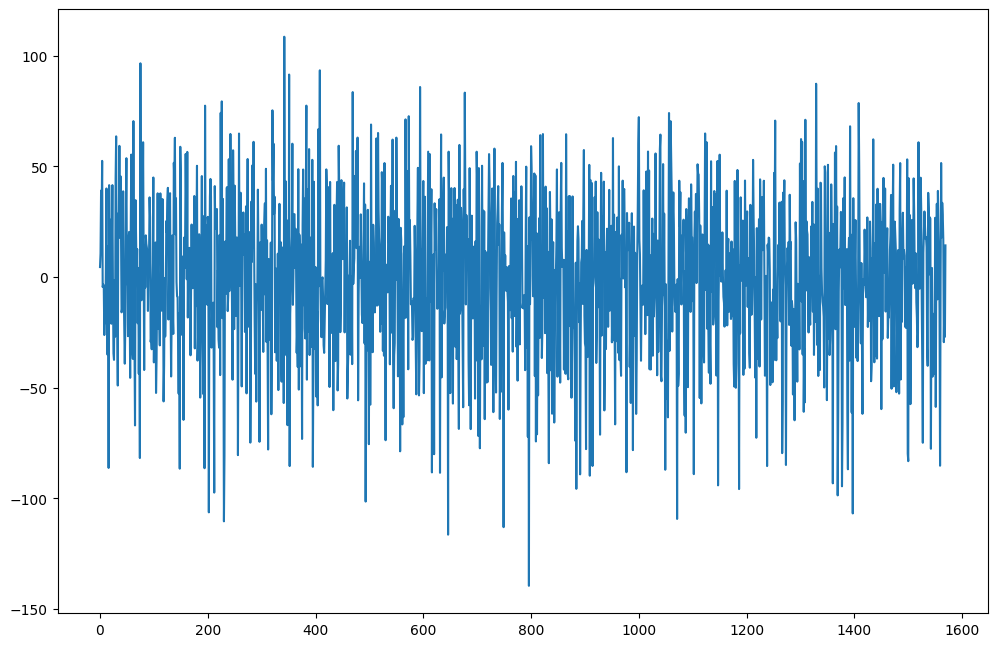

In [6]:
pol_losses = search_result['gr_results']
print(len(pol_losses))
plt.plot([x for pol in pol_losses for x in pol])

In [28]:
gr_dist_move = search_result['gr_dist_collector']
print(len(gr_dist_move))
print(len(gr_dist_move[0]))

5
2


In [8]:
childnet = WideResNet(40, 2, dropout_rate=0.0, num_classes=num_classes).cuda()
path = "/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/cifar10_wresnet40_2_default_ratio0.4_fold0.model"
ckpt = torch.load(path)
if 'model' in ckpt:
    childnet.load_state_dict(ckpt['model'])
else:
    childnet.load_state_dict(ckpt)
childnet.feature_out = True
# _, trainloader, validloader, testloader = get_dataloaders("cifar10_svhn", 128,"/home/server32/data",0.4)
loader = torch.utils.data.DataLoader(
                    total_trainset, batch_size=128, shuffle=False, num_workers=4,
                    drop_last=False)
features = []
for data, label in loader:
    data = data.cuda()
    feature = childnet(data)
    features.append(feature.cpu().detach().numpy())
    del data, label
del childnet
fts = np.concatenate(features)
print(fts.shape)

(50000, 128)


In [9]:
model = TSNE(learning_rate=200, n_iter=1000, perplexity=50, verbose=1, n_jobs=-1)
transformed = model.fit_transform(fts)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.957s...
[t-SNE] Computed neighbors for 50000 samples in 42.597s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

In [37]:
xs = transformed[:,0]
ys = transformed[:,1]
np.savez("tsne.npz", xs=xs,ys=ys)

In [8]:
tsne = np.load("tsne.npz")
xs = tsne['xs']
ys = tsne['ys']

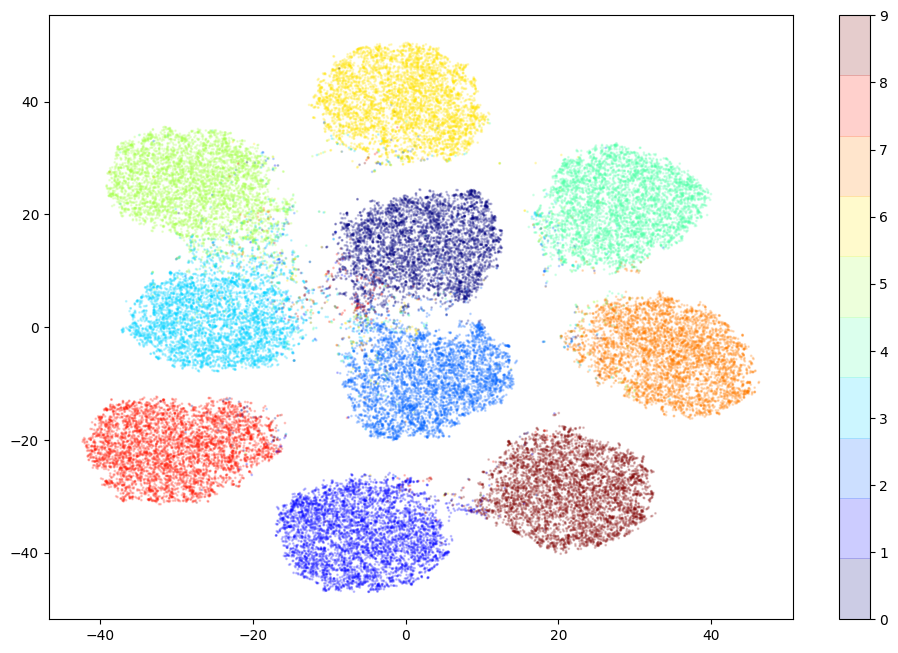

In [11]:
cmap = cm.get_cmap('jet', num_classes)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=total_trainset.targets, cmap=cmap)
plt.colorbar()
plt.show()

Counter({3: 8935, 1: 5792, 8: 5616, 2: 5610, 0: 5592, 6: 4841, 4: 4188, 5: 4030, 9: 3262, 7: 2134})
Counter({4: 23405, 0: 12324, 5: 2594, 3: 2507, 1: 2029, 8: 2010, 9: 1767, 2: 1477, 6: 1241, 7: 646})
Counter({6: 21047, 3: 5076, 1: 4670, 5: 4214, 4: 3625, 0: 3349, 8: 2258, 2: 2148, 7: 1841, 9: 1772})
Counter({0: 24126, 4: 10569, 5: 2823, 1: 2608, 3: 2472, 8: 2289, 9: 1914, 2: 1335, 6: 1142, 7: 722})
Counter({1: 14710, 3: 5759, 5: 5385, 4: 5295, 0: 5049, 6: 4872, 8: 2398, 9: 2267, 2: 2236, 7: 2029})
Counter({0: 17559, 8: 14784, 3: 4150, 4: 3811, 1: 3126, 5: 2129, 9: 1912, 2: 1031, 6: 844, 7: 654})
Counter({4: 25101, 5: 4272, 1: 3879, 8: 3736, 3: 2881, 0: 2707, 9: 2659, 6: 1823, 2: 1690, 7: 1252})
Counter({0: 17881, 8: 14474, 4: 3375, 1: 3322, 3: 2830, 9: 2084, 5: 1909, 6: 1517, 2: 1499, 7: 1109})
Counter({4: 24289, 5: 5041, 1: 4335, 0: 3629, 8: 2903, 3: 2779, 9: 2520, 6: 1833, 2: 1497, 7: 1174})
Counter({8: 22162, 0: 12192, 1: 3299, 3: 3184, 4: 2731, 5: 1708, 6: 1636, 9: 1206, 2: 988, 7

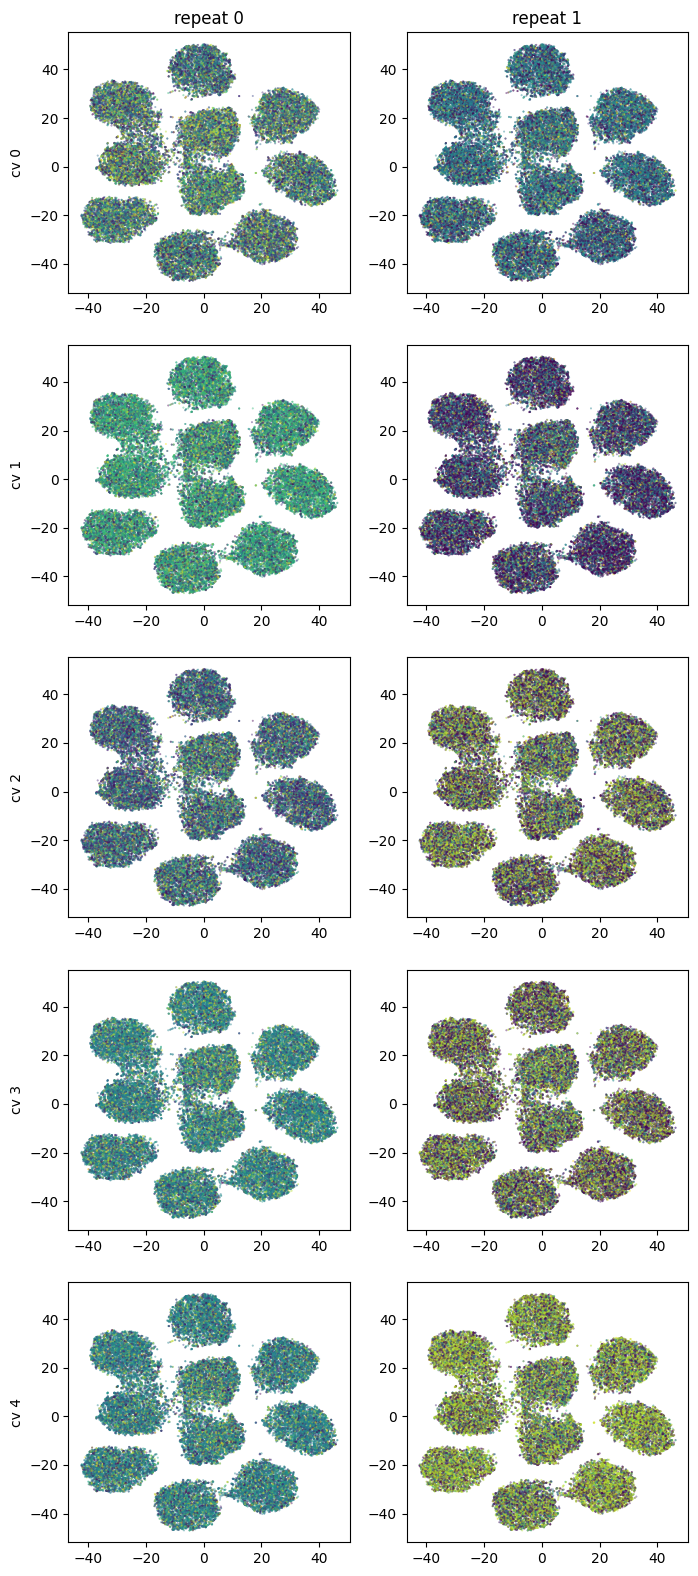

In [29]:
fig, axes = plt.subplots(cv_num, repeat, figsize=(4*repeat,4*cv_num))
for cv_id in range(cv_num):
    for r, id_dist in enumerate(gr_dist_move[cv_id]):
        ax = axes[cv_id][r]
        ax.scatter(xs, ys, c=id_dist, s=0.2, alpha=0.5, label=Counter(id_dist))
        print(Counter(id_dist))
        if r == 0:
            ax.set_ylabel(f"cv {cv_id}")
        if cv_id == 0:
            ax.set_title(f"repeat {r}")
#         ax.legend()
plt.show()

In [30]:
print(Counter(gr_dist_move["last"]))
plt.scatter(xs, ys, s=2., alpha=0.4, c=gr_dist_move["last"])

KeyError: 'last'

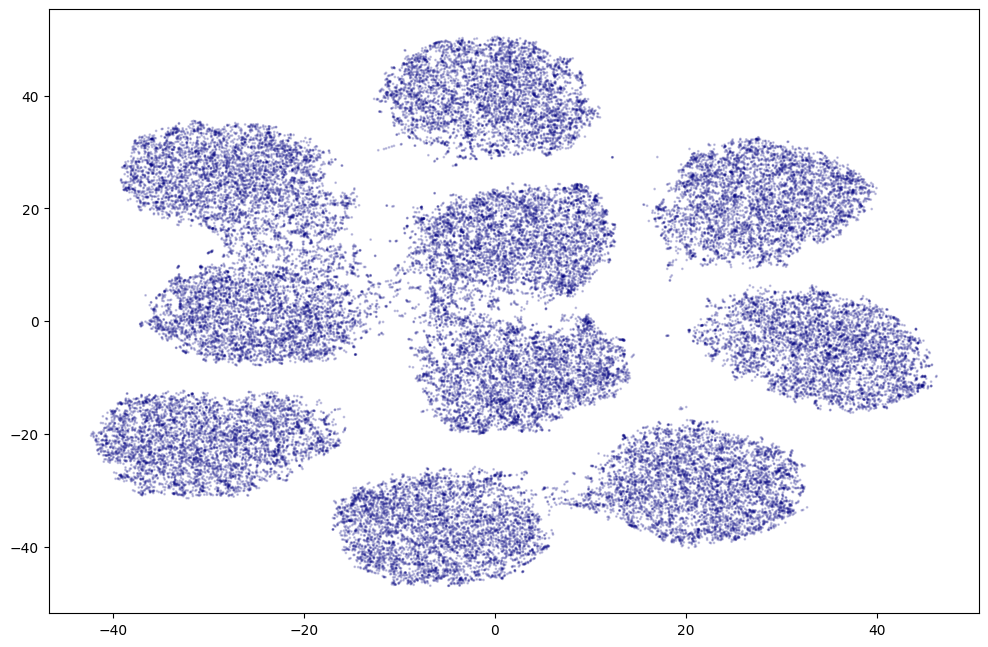

In [13]:
cmap = cm.get_cmap('jet', 2)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=[1 if x<10 else 2 for x in total_trainset.targets], cmap=cmap)
plt.show()

In [27]:
# gr_ids
_, trainloader, validloader, testloader = get_dataloaders("cifar10_svhn", 128, "/home/server32/data/", 0.0, gr_id=0, gr_ids=gr_ids)

10000


In [26]:
print(len(testloader.dataset))

19153


In [6]:
load_path = "/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/logging_b1000/search_cifar10_svhn_wresnet40_2_group2_4_cv0_ratio0.4_bo_result.csv"
result_csv = pd.read_csv(load_path)
minus_loss = result_csv['minus_loss']
acc = result_csv["top1_valid"]

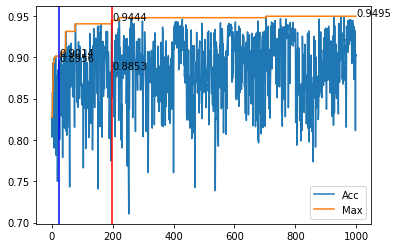

In [7]:
maxline = [max(acc[:x]) for x in range(1,len(acc))]
plt.plot(acc, label="Acc")
plt.plot(maxline, label="Max")
plt.axvline(x=199,c='red')
plt.text(200, acc[199], "{:.4f}".format(acc[199]))
plt.text(200, maxline[198], "{:.4f}".format(maxline[198]))
plt.axvline(x=24,c='blue')
plt.text(25, acc[24], "{:.4f}".format(acc[24]))
plt.text(25, maxline[23], "{:.4f}".format(maxline[23]))
plt.text(len(acc), maxline[-1], "{:.4f}".format(maxline[-1]))
plt.legend()
plt.show()